In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def binary_ce(p, y):
    return -1*(y*np.log2(p) + (1 - y)*np.log2(1-p))

def grad_binary_ce(p, y):
    return -1*((y / p) + (1 - y) / (1 - p))

def sigmoid(X, w, b):
    z = 1 + np.exp(-1*(np.dot(w, X)+ b))
    return 1 / z

def grad_sigmoid(X, w, b):
    activations = sigmoid(X, w, b)
    return activations*(1 - activations)*w[:, np.newaxis].repeat(X.shape[1], axis=1)
    
def diff_loss(X, source, source_label, w, b):
    p_X = sigmoid(X, w, b)
    p_source = sigmoid(source, w, b)
    loss_X = binary_ce(p_X, source_label)
    loss_source = binary_ce(p_source, source_label)
    return loss_X - loss_source
    
def adv_gain(X, source, source_label, w, b):
    p_X = sigmoid(X, w, b)
    p_source = sigmoid(source, w, b)
    dist_diff = np.linalg.norm(X - source, axis=0)
    loss_X = binary_ce(p_X, source_label)
    loss_source = binary_ce(p_source, source_label)
    return np.abs(loss_X - loss_source) / dist_diff


def grad_adv_gain(X, source, source_label, w, b):
    X_diff = X - source
    dist_diff = np.linalg.norm(X_diff, axis=0)
    D = diff_loss(X_diff, source, source_label, w, b)
    sigmoid_val = sigmoid(X_diff, w, b)
    
    bce_grad = grad_binary_ce(sigmoid_val, source_label)
    sigmoid_grad = grad_sigmoid(X, w, b)
    loss_grad = bce_grad*sigmoid_grad
    
    return -1*(np.sign(D)*loss_grad*dist_diff - (np.abs(D)*(X / dist_diff))) / dist_diff**2
    
def line_generator(range_vals, w, b):
    return -1*(b + w[0]*range_vals) / w[1]

source = np.array([[0],[1]])
X = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8]])
w = np.array([1 ,-1])
b = 2

print(diff_loss(X, source, 1, w, b))
print(grad_sigmoid(X, w, b))
# print(grad_adv_gain(X, source, source_label, w, b))

[2.61656741 2.61656741 2.61656741 2.61656741]
[[ 0.10499359  0.10499359  0.10499359  0.10499359]
 [-0.10499359 -0.10499359 -0.10499359 -0.10499359]]


(2, 71824)
(268, 268) (268, 268)
25540
0.4546978473235583
(80, 95)
-8.0 -20.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


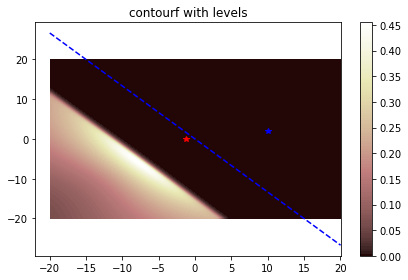

In [55]:
# make these smaller to increase the resolution
dx, dy = 0.15, 0.15

# generate 2 2d grids for the x & y bounds
bound_x = 20
bound_y = 20
y, x = np.mgrid[slice(-bound_y, bound_y + dy, dy),
                slice(-bound_x, bound_x + dx, dx)]
x_sample = x[::2, ::2]
y_sample = y[::2, ::2]

source = np.array([[10], [2]])
source_label = 1
w = 1*np.array([4 , 3])
b = 0

plot_x = x[0].copy()
plot_y = line_generator(plot_x, w, b)
# plot_y = plot_y[plot_y > -5] 
# plot_x = plot_x[:len(plot_y)]


# X, Y = np.meshgrid(x, y)
XY = np.vstack([x.flatten(), y.flatten()])
XY_sample = np.vstack([x_sample.flatten(), y_sample.flatten()])
print(XY.shape)
print(x.shape, y.shape)
z = np.linalg.norm(adv_gain_1d(XY, source, w, b), axis=0).reshape(x.shape[0], y.shape[0])
max_val_index  = np.argmax(z)
print(max_val_index)
print(z.max())
print((max_val_index % x.shape[0], max_val_index // y.shape[0]))
max_val_x, max_val_y = (max_val_index % x.shape[0], max_val_index // y.shape[0])
x_max , y_max = (XY[0, max_val_x], XY[1, max_val_y])
print(x_max, y_max)
# z = np.linalg.norm(grad_adv_gain(XY, source, source_label, w, b), axis=0).reshape(x.shape[0], y.shape[0])
adv_grad = grad_adv_gain(XY_sample, source, source_label, w, b)
U = adv_grad[0].reshape(x_sample.shape[1], y_sample.shape[1])
V = adv_grad[1].reshape(x_sample.shape[1], y_sample.shape[1])

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
levels = MaxNLocator(nbins=100).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('pink')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
print(cmap)
fig, (ax0) = plt.subplots(nrows=1)

# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
# fig.colorbar(im, ax=ax0)
# ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax0.contourf(x + dx/2.,
             y + dy/2., z, levels=levels,
             cmap=cmap)
fig.colorbar(cf, ax=ax0)
ax0.set_title('contourf with levels')
ax0.plot(source[0], source[1], 'b*')
ax0.plot(plot_x, plot_y, 'b--')
ax0.plot(-1.28, -0.07, 'r*')
# ax0.quiver(x_sample, y_sample, U, V)
# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


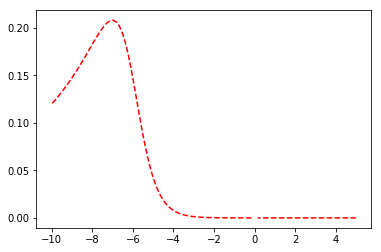

In [11]:
def adv_gain_1d(x, a, w, b):
    n_x = np.linalg.norm(x, axis=0)
    z = np.exp(-1*(np.dot(w, (x + a)) + b))
    z_s = np.exp(-1*(np.dot(w, a) + b))
    D = np.log((1 + z) / (1 + z_s))
#     print(z.shape, z_s.shape, D.shape)
#     print((D/X).shape)
#     print(((D/x) +w*(z / (1 + z))).shape)
    return  -1*np.sign(D)*(1 / n_x)*(w[:, np.newaxis]*(z / (1 + z)) + x*(1 / n_x**2)*D)
#     return -1*(np.linalg.norm(x[:, np.newaxis], axis=1)/ x   )*np.sign(D)*(1 / x)*((D/x) +w*(z / (1 + z)))

w = np.array([2])
b = np.array([2])
source = np.array([5])
source_label = 1
x = np.linspace(5, -10.0, num=100).reshape(100, 1).T
# print(x)
# loss_vals = binary_ce(sigmoid(x, w, b), 1)
grad_vals = np.abs(adv_gain_1d(x, source, w, b))
# print(grad_vals)
# plt.plot(x[0], loss_vals)
plt.plot(x[0], grad_vals[0], 'r--') 

In [23]:
a = np.array([[1, 3], [4, -2]])


3